In [286]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [223]:
class XData():
    def __init__(self, X0):
        self.X = X0
        self.names = ['Ni','Co','Cr','V','Si','O']

    def __getitem__(self,key):
        if type(key)==str:
            if key in self.names:
                i = self.names.index(key)
        else:
            i = key
        return self.X[i]
    
    def __setitem__(self,key,value):
        if type(key)==str:
            if key in self.names:
                i = self.names.index(key)
        else:
            i = key
        self.X[i] = value   

class EpsilonData():
    def __init__(self, ep_ij):
        self.names = ['Ni','Co','Cr','V','Si','O']
        self.ep_ij = ep_ij
        self.T0 = 1873
        self.T = self.T0
    def set_T(self,T):
        self.T = T
        
    def __getitem__(self,key):
        if type(key[0])==str:
            if key[0] in self.names:
                i = self.names.index(key[0])
        else:
            i = key[0]
        if type(key[1])==str:
            if key[1] in self.names:
                j = self.names.index(key[1])
        else:
            j = key[1]            
        return self.ep02T(self.ep_ij[i,j],self.T)
    
    def __setitem__(self,key,value):
        if type(key[0])==str:
            if key[0] in self.names:
                i = self.names.index(key[0])
        else:
            i = key[0]
        if type(key[1])==str:
            if key[1] in self.names:
                j = self.names.index(key[1])
        else:
            j = key[1]
        self.ep_ij[i,j] = value
        
    def ep02T(self, ep_T0, T):
        return self.T0/T*ep_T0

class Fits():
    def __init__(self, fits):
        self.fits = fits
        self.names = ['Ni','Co','Cr','V','Si','O']

    def __getitem__(self,key):
        if type(key)==str:
            if key in self.names:
                i = self.names.index(key)
        else:
            i = key
        return self.fits[i]
    
    def __setitem__(self,key,value):
        if type(key)==str:
            if key in self.names:
                i = self.names.index(key)
        else:
            i = key
        self.fits[i] = value   

class FitData():
    def __init__(self,a=0,b=0,c=0,ep_i_O=0,ep_i_Si=0, ln_gamma_i0_a=0,ln_gamma_i0_b=0):
        self.a = a
        self.b = b
        self.c = c
        self.ep_i_j = {'Ni':0,'Co':0,'Cr':0,'V':0,'O':ep_i_O,'Si':ep_i_Si}
        self.ln_gamma_i0_a = ln_gamma_i0_a
        self.ln_gamma_i0_b = ln_gamma_i0_b  
    
    def ln_gamma_i0(self,T):
        return self.ln_gamma_i0_a+self.ln_gamma_i0_b/T

In [281]:
def all_logD(T,X,ep,fits,P,X_FeO):
    lDs = []
    for n in names:
        lDs.append(log_D(n,T,X,ep,fits,P,X_FeO))
    return np.array(lDs)

def log_D(i, T, X, ep, fits, P, X_FeO):
    X_Fe = 1-np.sum(X.X)
    if type(i) is str:
        ii = names.index(i)
    else:
        ii = i
    n = valence[ii]
    f = fits[i]
    return f.a + f.b/T + f.c*P/T - n/2*np.log(X_FeO/X_Fe) - ln_gamma(i,T,X,ep,fits) + n/2*ln_gamma_Fe(T,X,ep)

def ln_gamma_Fe(T, X, ep):
    ep.set_T(T)
    s1 = 0
    for i in names:
        s1 += ep[i,i]*(X[i]+np.log(1-X[i]))
    s2 = 0
    for j in range(N-1):
        for k in range(j+1,N-1):
            if X[j]!=0. and X[k]!=0.:
                s2 += ep[j,k]*X[j]*X[k] * (1 + np.log(1-X[j])/X[j] + np.log(1-X[k])/X[k] )
    s3 = 0
    for i in range(N-1):
        for k in range(N-1):
            if not i==k:
                if X[k]!=0.:
                    s3 += ep[i,k]*X[i]*X[k]*(1+np.log(1-X[k])/X[k] - 1/(1-X[i]) )
    s4 = 0
    for j in range(N-2):
        for k in range(j+1,N-1):
            s4 += 0.5*ep[j,k]*X[j]**2 * X[k] **2 * ( 1/(1-X[j]) + 1/(1-X[k]) -1)
    s5 = 0
    for i in range(N-1):
        for k in range(N-1):
            if not i==k:
                s5 += ep[i,k]*X[i]**2*X[k]**2*(1/(1-X[i]) + 1/(1-X[k]) + X[i] / (2*(1-X[i])**2) -1)
    return s1-s2+s3+s4-s5
        
def ln_gamma(i, T, X, ep, fits):
    if type(i) is str:
        ii = names.index(i)
    else:
        ii = i
    ep.set_T(T)
    s1 = ln_gamma_Fe(T,X,ep)
    s2 = fits[i].ln_gamma_i0(T)
    s3 = ep[i,i]*np.log(1-X[i])
    s4 =0
    for j in range(N-1):
        if not j==ii:
            if X[j]!=0.:
                s4 += ep[i,j]*X[j]*(1+np.log(1-X[j])/X[j] - 1/(1-X[i]))
    s5 = 0
    for j in range(N-1):
        if not j==ii:
            s5 += ep[i,j]*X[j]**2*X[i]*(1/(1-X[i]) + 1/(1-X[j]) + X[i]/(2*(1-X[i])**2) - 1)
    return s1+s2-s3-s4+s5
            
def ep_T(ep_T0,T):
    T0 = 1873
    return T0/T*ep_T0


In [275]:
names = ['Ni','Co','Cr','V','Si','O']
valence = [10, 9,6, 5,4,6]
N = len(names) + 1

eparr = np.zeros((len(names),len(names)))
ep = EpsilonData(eparr)

ep['Ni','O'] = 1.4
ep['Co','O'] = 1.89
ep['Cr','O'] = -7.2
ep['V','O'] = -21.1
ep['Si','O'] = -5
ep['O','O'] = -1

ep['Ni','Si'] = 1.16
ep['Co','Si'] = 0
ep['Cr','Si'] = 0
ep['V','Si'] = 2.
ep['Si','Si'] = 12.41
ep['O','Si'] = -5

fits = Fits([None]*(N-1))
fits['Ni'] = FitData(.304, 2916, -60, 1.4, 1.16, 0, -0.42*1873) # Nickel
fits['Co'] = FitData(.287, 1360, -35, 1.89, 0, 0, -0.6*1873) # Cobalt
fits['Cr'] = FitData(.082, -3379, 0, -7.2, 2, 0, -2.53*1873) # Chromium
fits['V'] = FitData(-1.238, -5288, 0, -21.1, 2, 0, -2.53*1873) # Vanadium
fits['Si'] = FitData(.364, -16520,0,-5,12.41,0,-6.65*1873) # Silicon
fits['O'] = FitData(2.736, 11439, 0,-1,-5, 4.29, -16500) # Oxygen


In [276]:
X0 = np.array([0, 0, 0, 0, 0.000001, 0])
X = XData(X0)
T = 1873
ln_gamma('Si',T,X,ep,fits)

-6.64998759

In [277]:
X0 = np.array([0, 0, 0, 0, 0, 0.000001])
X = XData(X0)
T = 4000
ln_gamma('O',T,X,ep,fits)

0.16499953175000004

In [278]:
X_FeO = .06
X0 = np.array([0, 0, 0, 0, 0.05, 0.15])
X = XData(X0)
T = 4000
P = 135e9 # Pa

log_D('O',T, X, ep, fits, P, X_FeO)

13.459947876523048

In [298]:
import sys
sys.path.append('../')
import mg_si
re = mg_si.reactions.MgSi()


In [316]:
Ts = np.linspace(4800,6000, 1000)
X0 = np.array([0, 0, 0, 0, 0.05, 0.15])
P = 139
lDs = np.zeros((len(Ts),len(names)))
DFeO = np.zeros((len(Ts)))
DSiO2 = np.zeros((len(Ts)))
for i,T in enumerate(Ts):
    lDs[i,:] = all_logD(T,X,ep,fits, P, X_FeO)
    DFeO[i],_ = re.func_KD_FeO_val(T)
    DSiO2[i],_ = re.func_KD_SiO2_val(X0[-2],X0[-1],T)

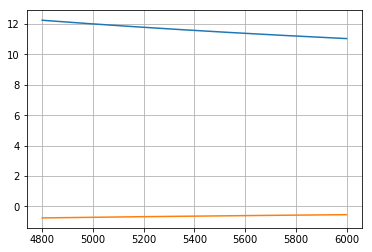

In [317]:
plt.plot(Ts, lDs[:,5])
plt.plot(Ts,np.log10(DFeO))
plt.grid()

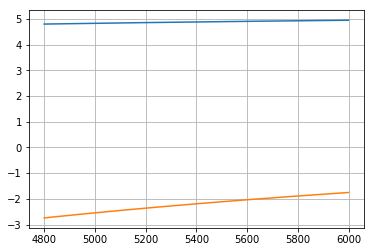

In [318]:
plt.plot(Ts, lDs[:,4])
plt.plot(Ts,np.log10(DSiO2))
plt.grid()